# Advanced Lane Finding Project (TestImage Pipeline Part2)

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## TestImage Pipeline ##

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

import pickle
import sys

import os
import pandas as pd
import matplotlib.gridspec as gridspec

import seaborn as sns

from PIL import Image
from skimage.transform import rescale, resize, rotate
from skimage.color import gray2rgb, rgb2gray
from skimage import transform, filters, exposure
from skimage.io import imread

from scipy.ndimage.interpolation import rotate

import platform

%matplotlib inline


## load saved pickle camera calibration parameters ##

In [2]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./pickled_data/calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


## test if loaded mtx dist is successfully working to correct image (warp) ##

In [3]:
# read chess board images 
imagefiles = glob.glob('./camera_cal/calibration*.jpg')
print(imagefiles)

['./camera_cal/calibration5.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration1.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration9.jpg', './camera_cal/calibration8.jpg']


In [4]:
test_image = imread('./camera_cal/calibration13.jpg')
nx = 9
ny = 6

In [6]:
def corners_unwarp(img, nx, ny, mtx, dist):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M


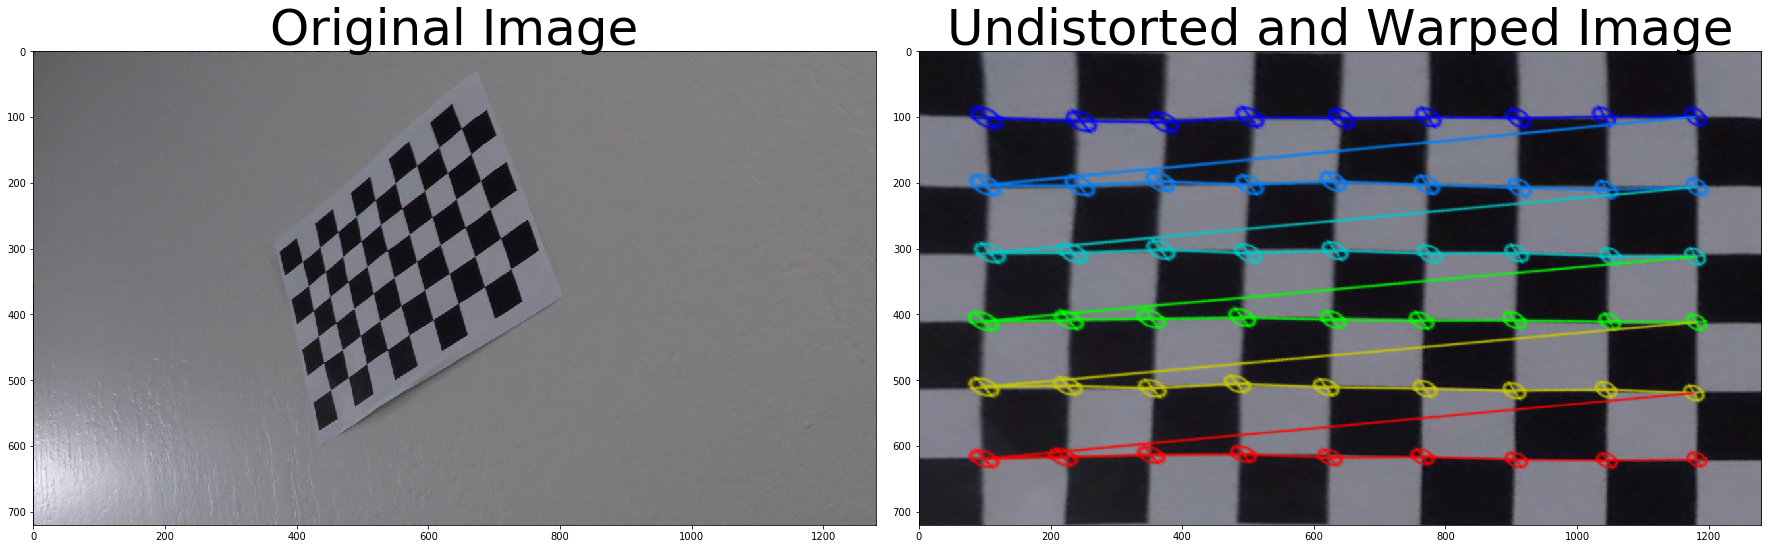

In [7]:
top_down, perspective_M = corners_unwarp(test_image, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## review onward project steps ## 
---

*    Camera calibration
*    Distortion correction
*    Color/gradient threshold
*    Perspective transform


# Disply Test Images #

In [58]:



def displayImage2x4(filenames,images,mysubtitle="Display Images",gray=False):

        gs1 = gridspec.GridSpec(4, 2)
        gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
        plt.figure(figsize=(26,22))
        plt.suptitle(mysubtitle, fontsize=24)
        for i in range(8):
            ax1 = plt.subplot(gs1[i])
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_aspect('equal')
            #img = transform_image(image,20,10,5,brightness=1)

            #plt.tight_layout()
            plt.subplot(4,2,i+1)
            if gray:
                plt.imshow(images[i], cmap = "gray")
            else:
                plt.imshow(images[i])
            plt.title(filenames[i],fontsize=18)
            plt.axis('off')

        plt.show()


In [75]:
filenames

['test6.jpg',
 'test5.jpg',
 'test4.jpg',
 'test1.jpg',
 'test3.jpg',
 'test2.jpg',
 'straight_lines2.jpg',
 'straight_lines1.jpg']

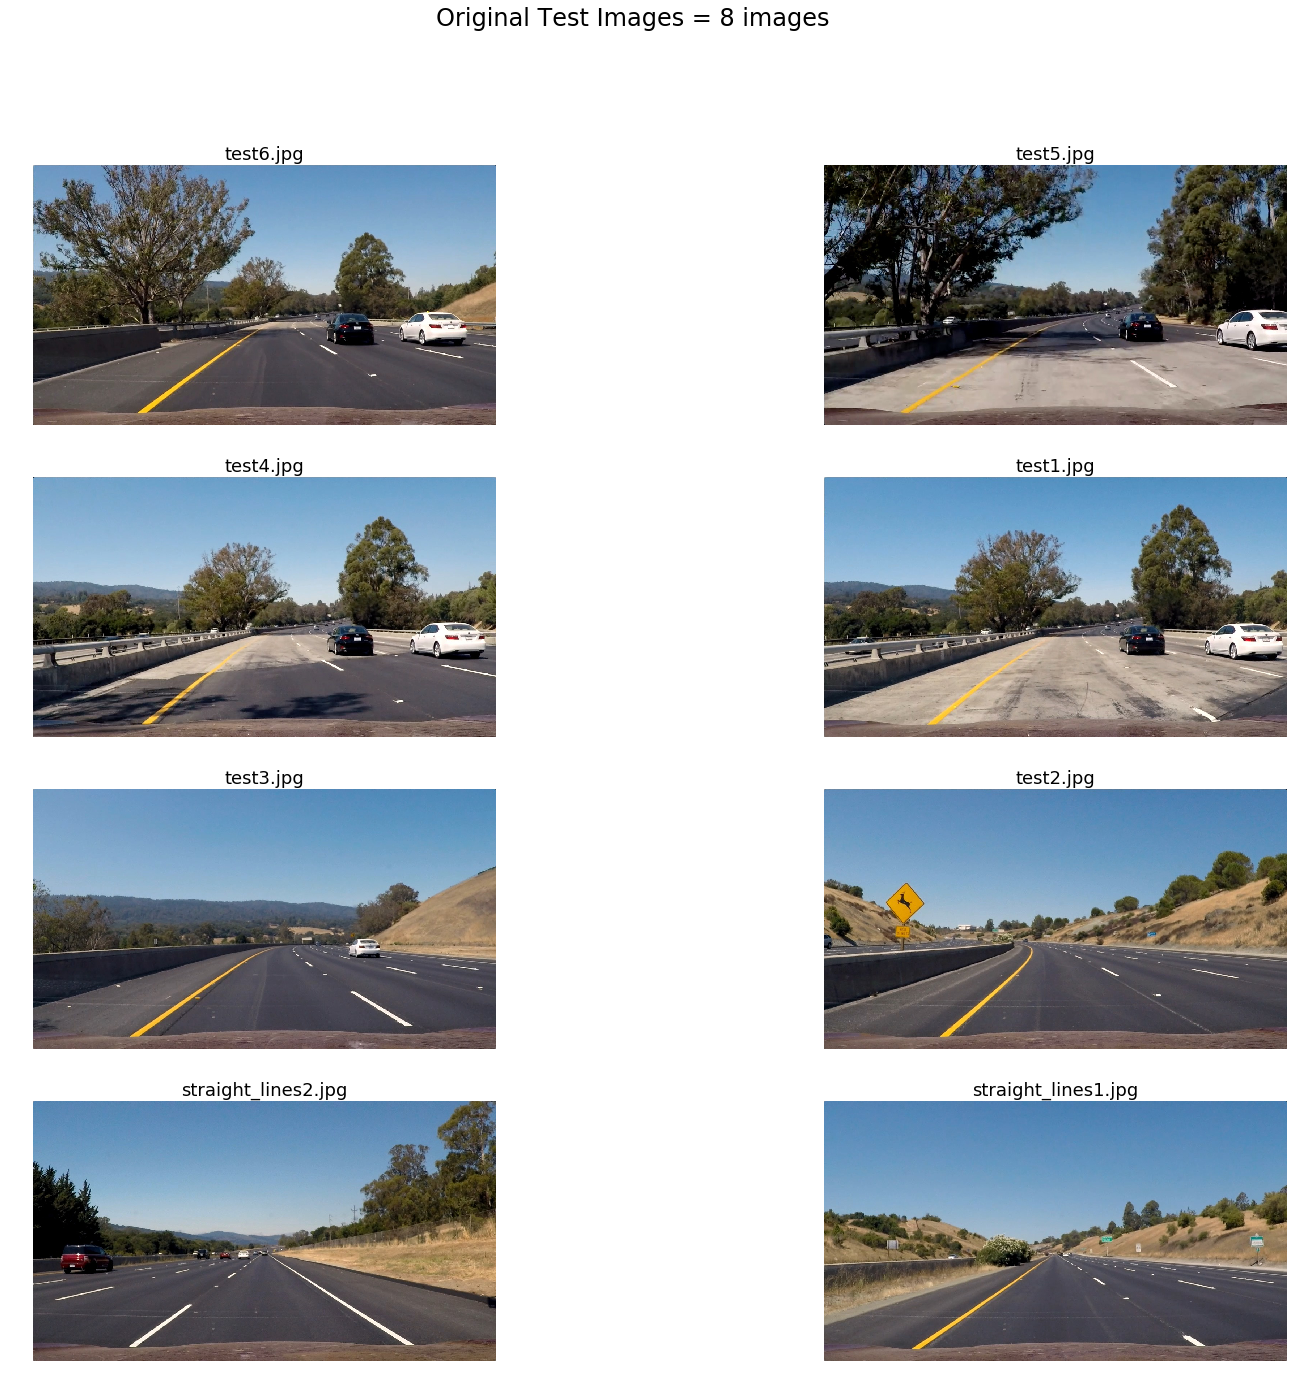

In [55]:
#
# load test images from test_images directory
#
# read with skimage.io.imread (RGB mode)

# then display 2x4

filenames = os.listdir("./test_images/")
images = list( map( lambda x: imread( os.path.join("./test_images",x)), filenames) )
displayImage2x4(filenames,images, "Original Test Images = 8 images ")

## Undistort image of  all testing images ##

***

* some of images are slightly cut from bottom line when applying cv2.undistort based on camera calibration parameters


In [36]:
#
#  with cv2 undistort :
#  input parameters       image
#                         mtx    <---- from camera calibration (pickle file)
#                         dist   <---- from camera calibration (pickle file)
#
#  images <-- skimage.io.image process (RGB format)
#
undist_images = list(map(lambda image:cv2.undistort(image, mtx, dist, None, mtx), images) )   

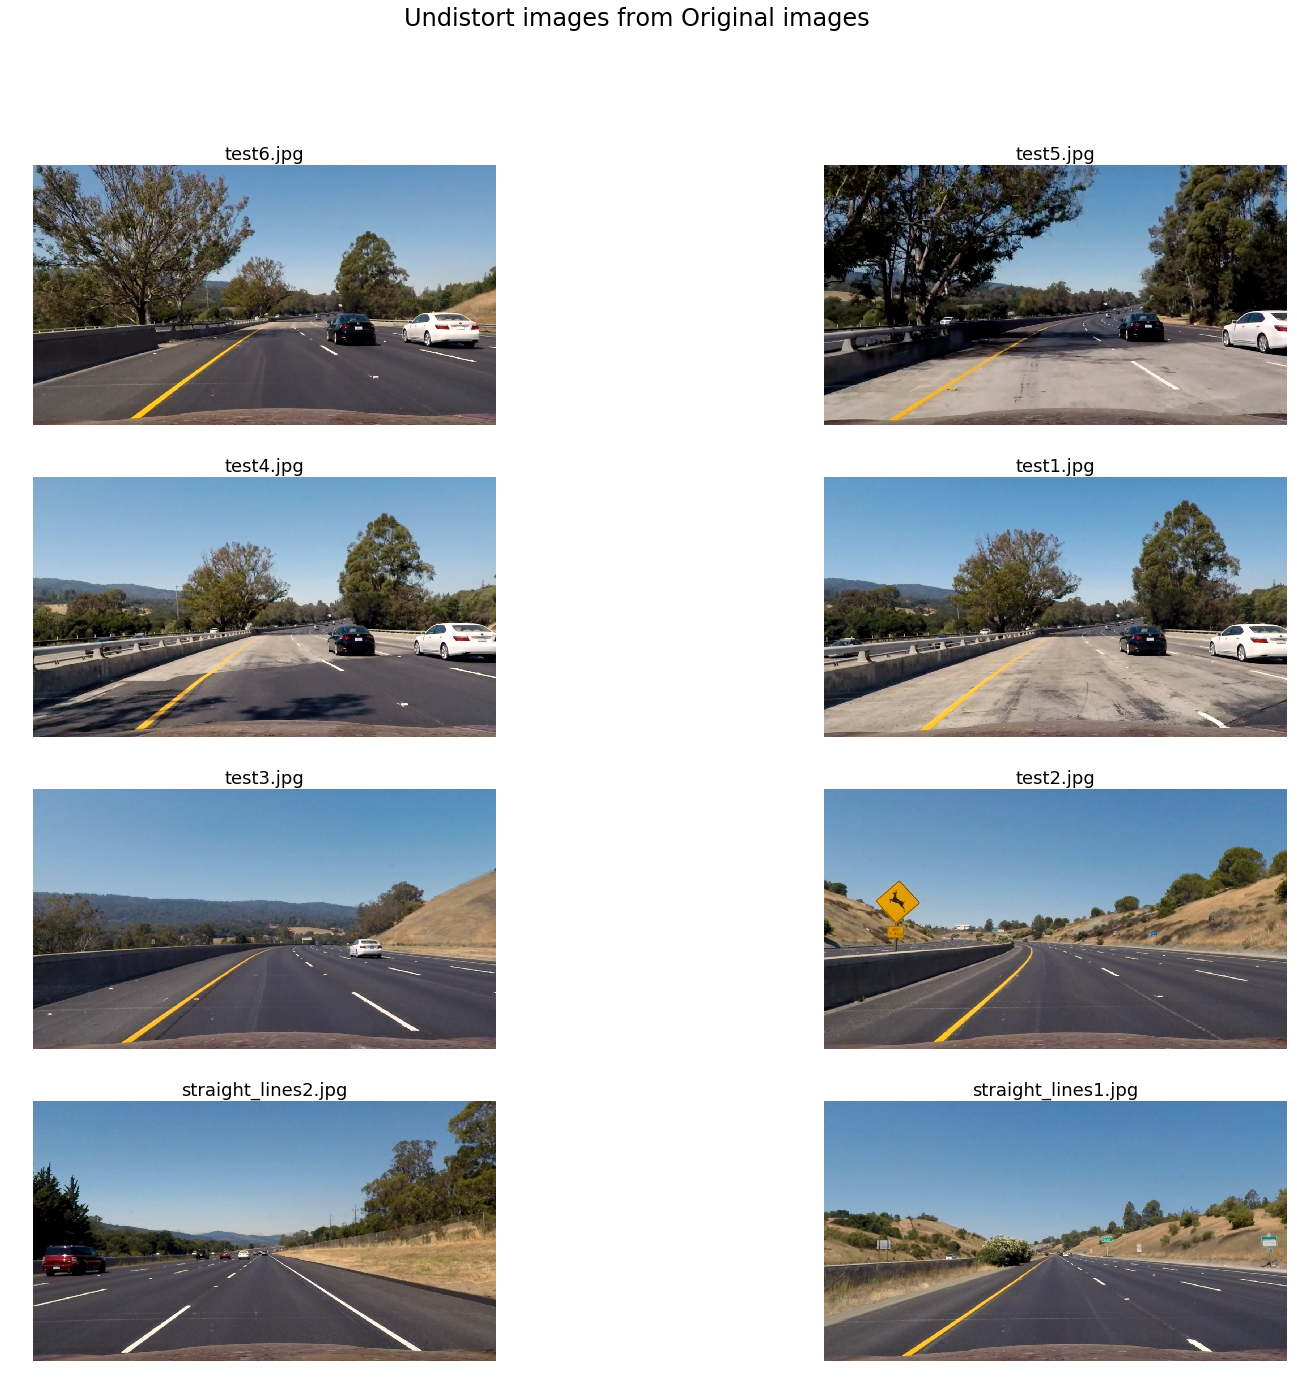

In [66]:
# 
#  display undistor test images 
#
displayImage2x4(filenames,undist_images,"Undistort images from Original images")

### common function to set threshhold values ###

In [38]:
def threshold(img, thresh_min=0, thresh_max=255):
    # 
    # Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    # 
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh_min) & (img <= thresh_max)] = 1
    
    return xbinary
    

## Finding Lanes (Sobel technique) ##

In [39]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0    
    
    # Apply the following steps to img
    # 1) Convert to grayscale (RGB -> GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, xorder, yorder)
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8( 255 * sobel / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = threshold(sobel,thresh_min,thresh_max)
    #sxbinary = np.zeros_like(sobel)
    #sxbinary[(sobel >= thresh_min) & (sobel <= thresh_max)] = 1
    return sxbinary
    
    # Run the function
    #grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
    # Plot the result

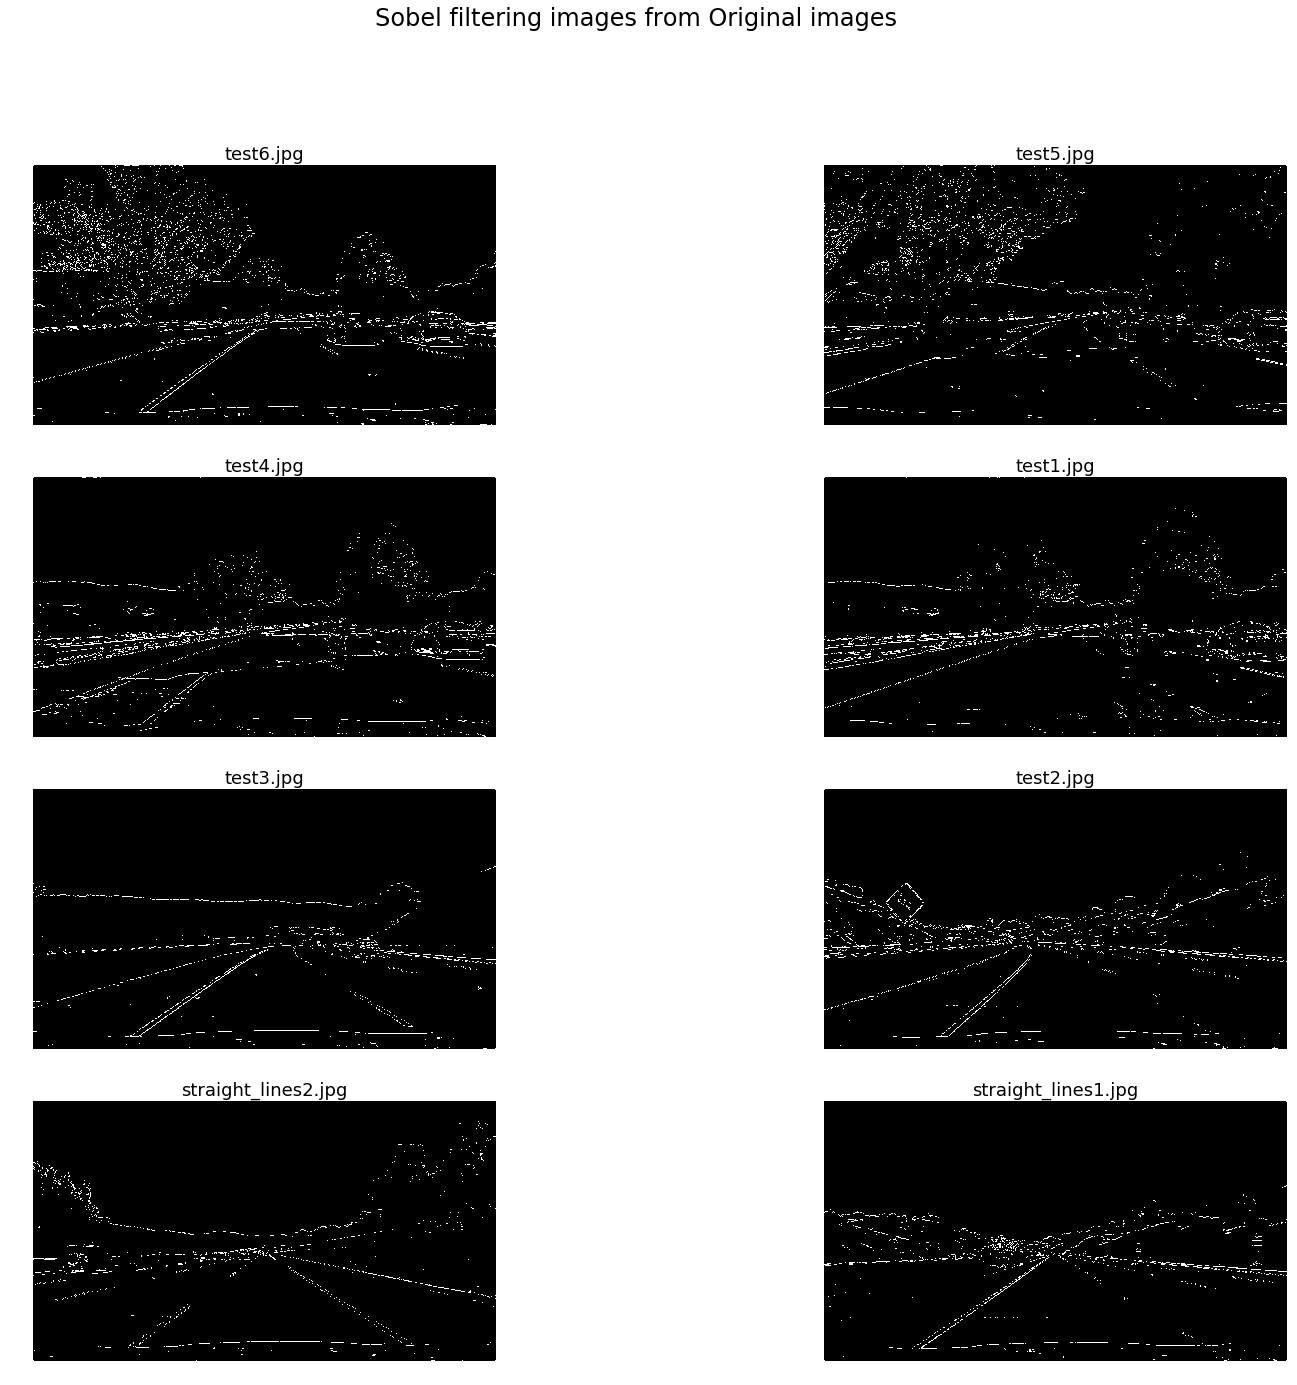

In [101]:
sobel_ops = lambda x:abs_sobel_thresh(x, orient='y', thresh_min=50, thresh_max=100)
sobel_images = list( map( sobel_ops, images) )

displayImage2x4(filenames,sobel_images,"Sobel filtering images from Original images",gray=True)

## Finding Lanes (Sobel Magnitude technique) ##

In [62]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # vertical and holizontal gradient 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    # magunitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel = np.sqrt( abs_sobelx **2 + abs_sobely ** 2  )
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8( 255 * sobel / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    
    sxbinary = threshold(sobel,mag_thresh[0],mag_thresh[1])
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary
    
    # Run the function
    #mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
    # Plot the result

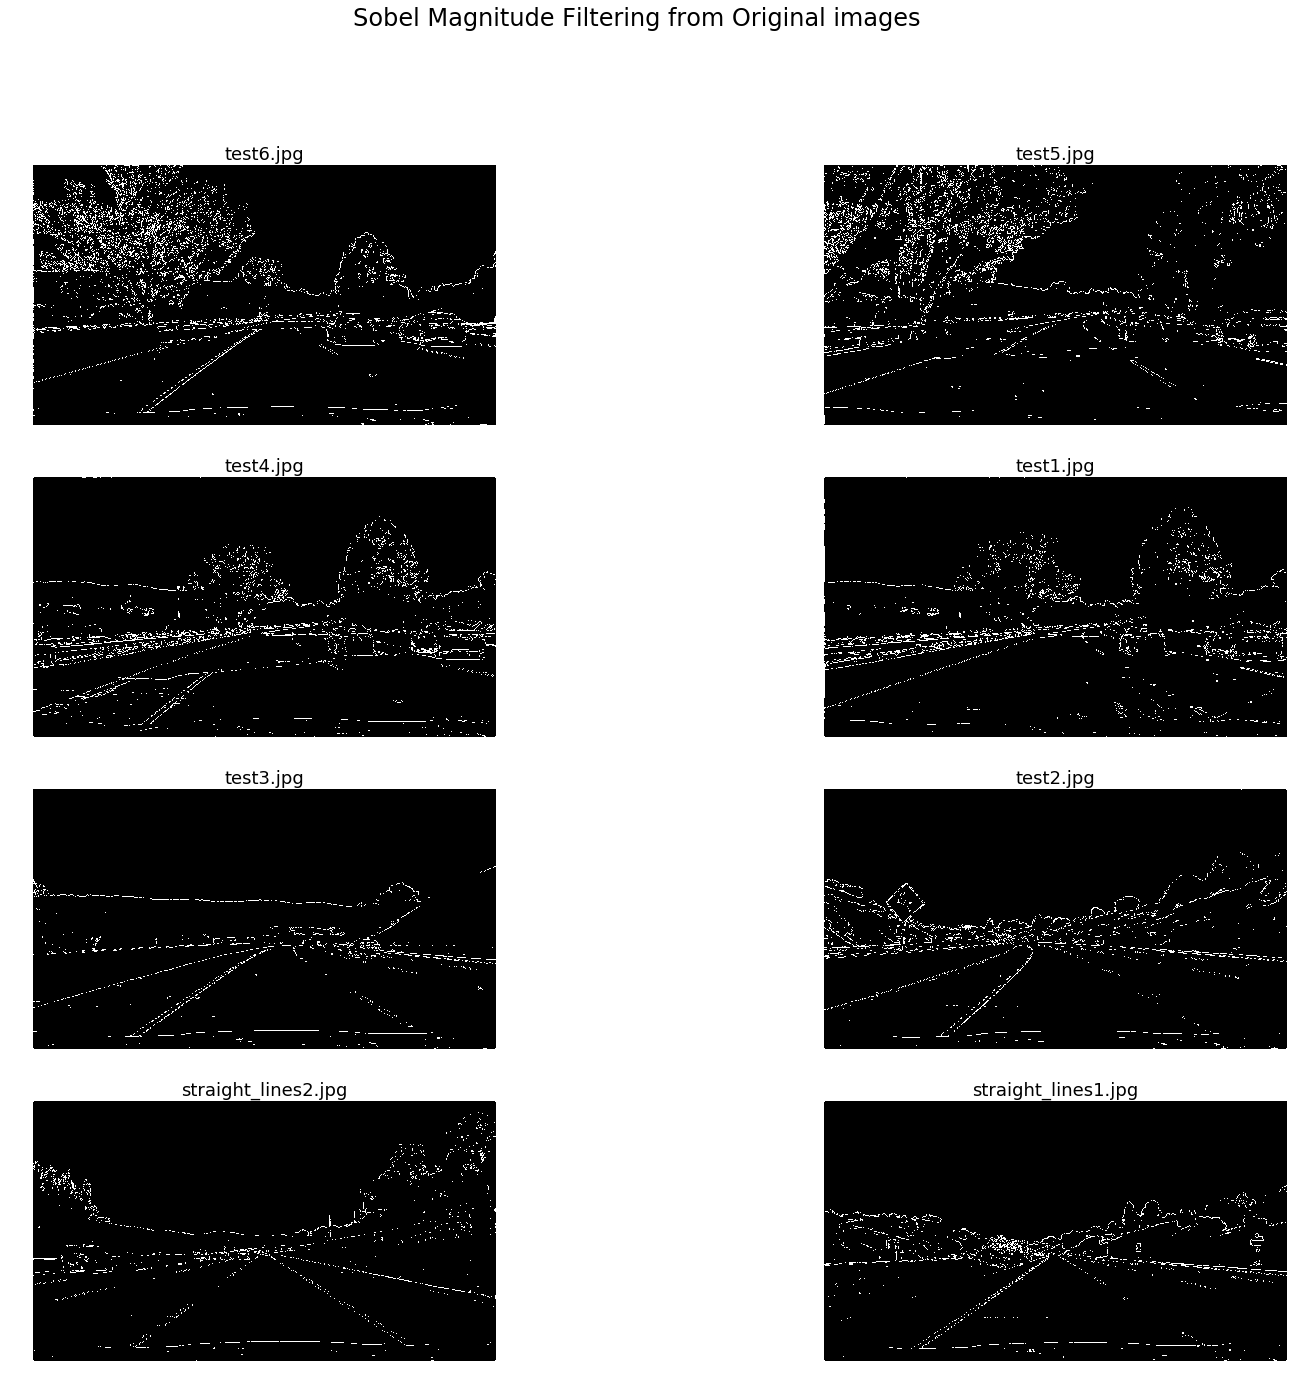

In [102]:
mag_ops = lambda x:mag_thresh(x, sobel_kernel=3, mag_thresh=(50, 100))
mag_images = list( map( mag_ops, images  ))

displayImage2x4(filenames,mag_images,"Sobel Magnitude Filtering from Original images",gray=True)

## Direction of Gradient filter ##

In [65]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    # magunitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel = np.arctan2(abs_sobely, abs_sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    #sobel = np.uint8( 255 * sobel / np.max(sobel))
    #print(sobel)
    # 5) Create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(sobel)
    sxybinary[(sobel > thresh[0]) & (sobel < thresh[1])] = 1    
    #binary_output = np.copy(img) # Remove this line
    return sxybinary
    

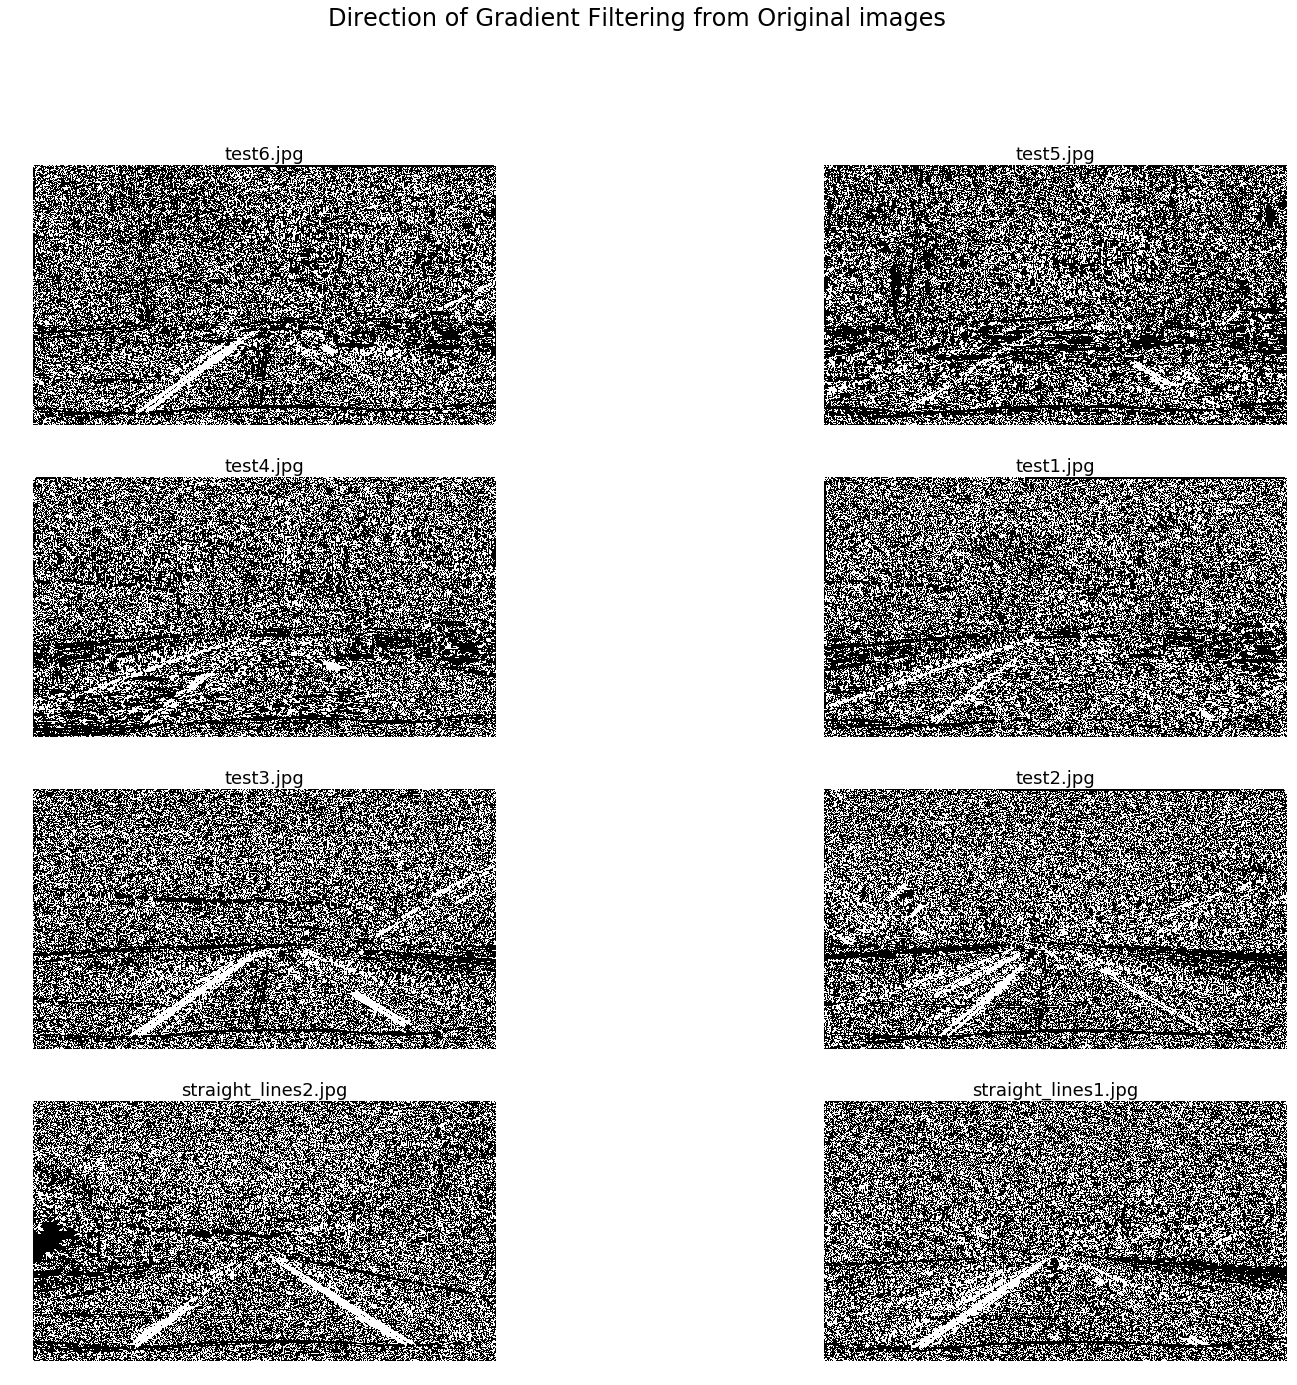

In [67]:
dir_ops = lambda x:dir_threshold(x, sobel_kernel=15, thresh=(0.7, 1.3))
dir_images = list( map(dir_ops, images))

displayImage2x4(filenames,dir_images,"Direction of Gradient Filtering from Original images",gray=True)

## Combination Technique (Sobel / Magnitude / Direction of Graditude) ##

In [104]:
def applyCombinedGradient(image):
    ksize=3
    sobel_imagex = abs_sobel_thresh(image, orient='x', thresh_min=50, thresh_max=100)
    sobel_imagey = abs_sobel_thresh(image, orient='y', thresh_min=50, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    mybinary = np.zeros_like(dir_binary)
    mybinary[ ((sobel_imagex == 1) & (sobel_imagey == 1)) | ( (mag_binary == 1) & (dir_binary == 1)      )      ] = 1

    return mybinary

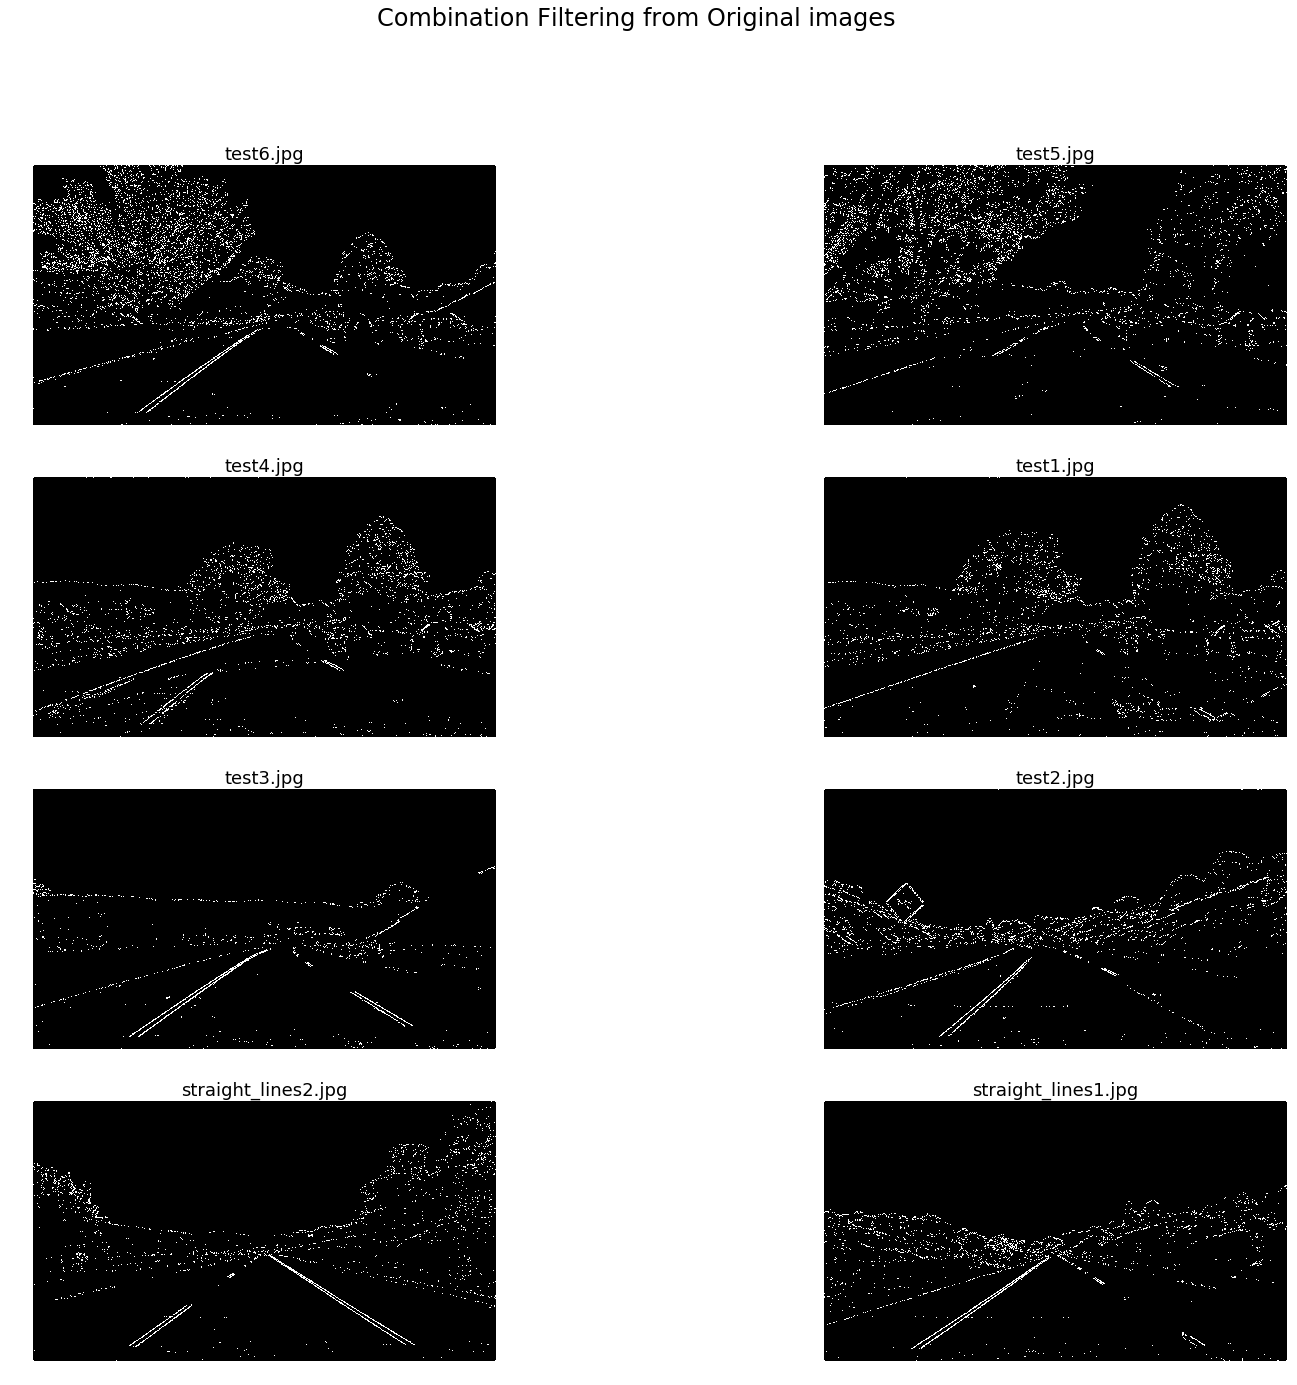

In [105]:
combination_binary_ops = lambda x:applyCombinedGradient(x)
combination_binary_images = list(map(combination_binary_ops,images))

#
# Now, it is time to make combination filtering (sobel / magnitude / direction) from original images
# to see how the lane lines are showed / filtered on binary image.


displayImage2x4(filenames,combination_binary_images,"Combination Filtering from Original images",gray=True)

### By applying several filtering technique on multi layered, lane lines are fairly enough to show, however we cannot extract lane lines of road images in accurate. In a special, test5.jpg has lots of contracts since tree shade is seen on the road, I could not draw lane line with binary image of Sobel / Direction, even combination technique.

## Now try to use HLS 

based on textbook comments

* Saturation also plays a part in this; saturation is a measurement of colorfulness. So, as colors get lighter and closer to white, they have a lower saturation value, whereas colors that are the most intense, like a bright primary color (imagine a bright red, blue, or yellow), have a high saturation value. 

So, I will try to extract lane lines with S channel filtering (tweak parameters) 

In [72]:
def s_threshold(img, thresh=(0, 255)):
    
    # input is RGB (skimage.io.imread)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]  # 2 <-- S channel     
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    return binary

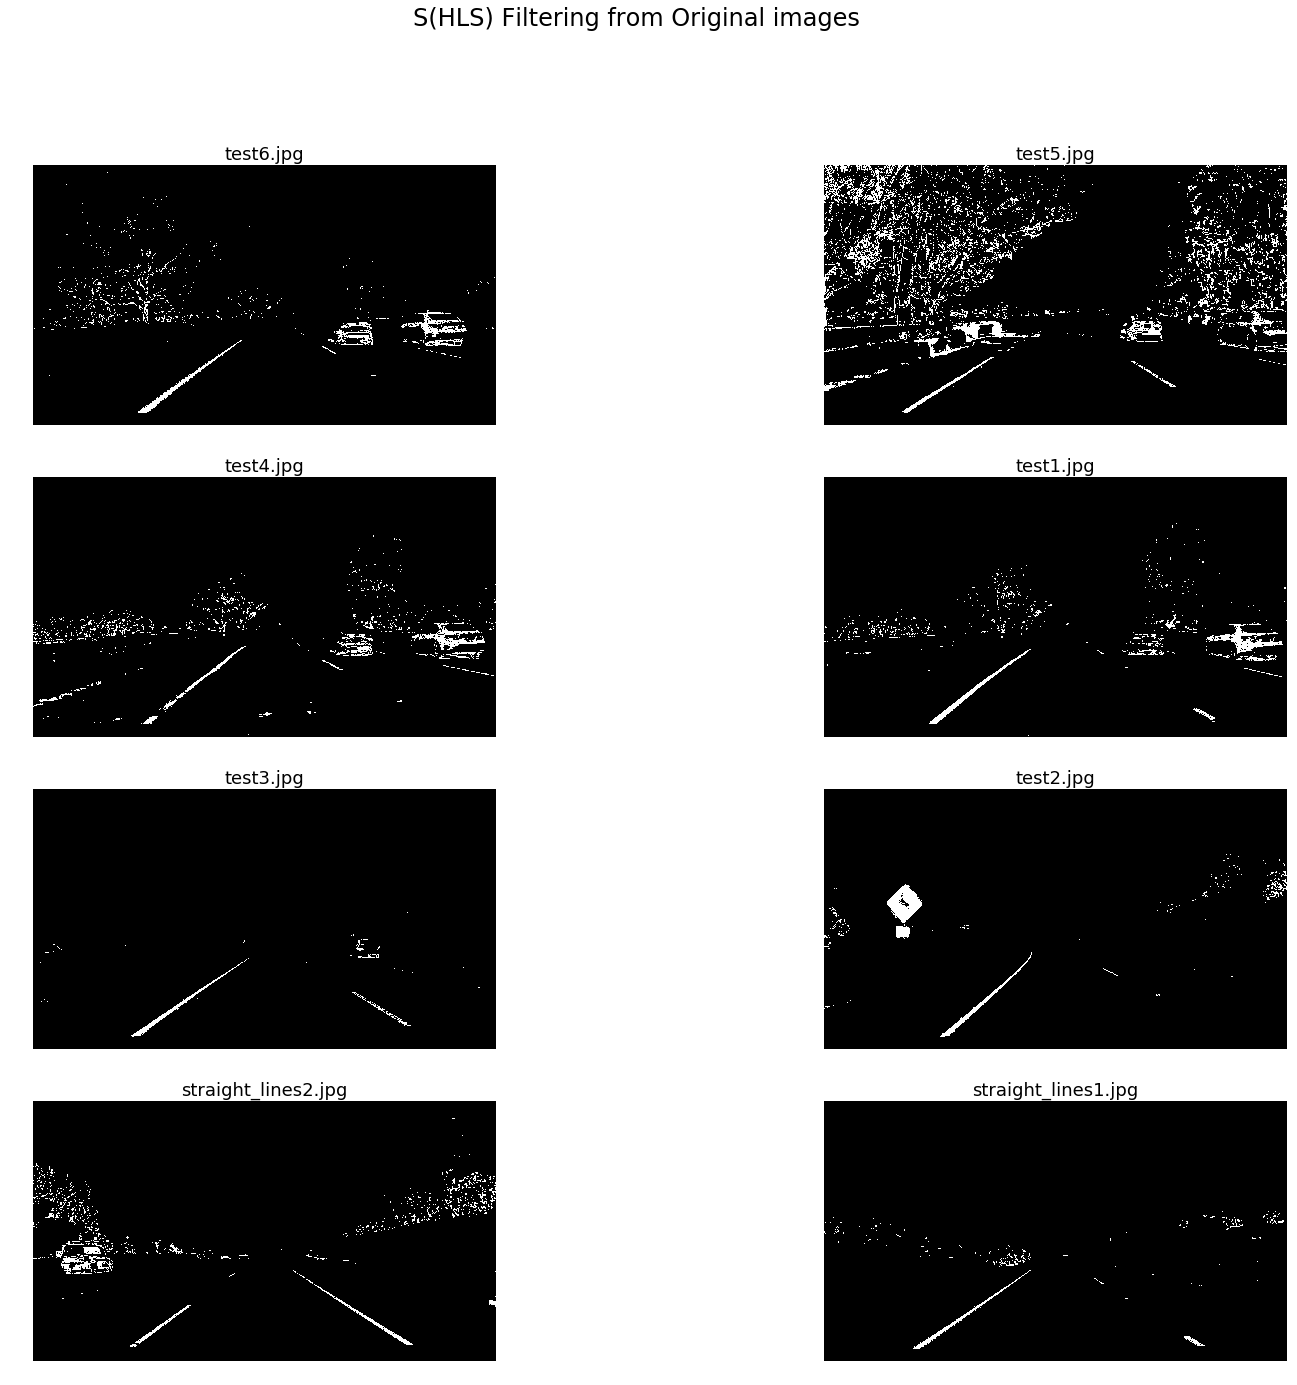

In [81]:
hls_ops = lambda x:s_threshold(x, thresh=(170,255))
hls_images = list(map( hls_ops, images ))

displayImage2x4(filenames,hls_images,"S(HLS) Filtering from Original images",gray=True)

## See the comparison image by Binary Filtering type
***
* I have picked up test5.jpg which has tree shade on left lane of the road, so that it could be difficult to pick up the lames.
* S channel is designated to be a robust expression to highlight lane line from road image.

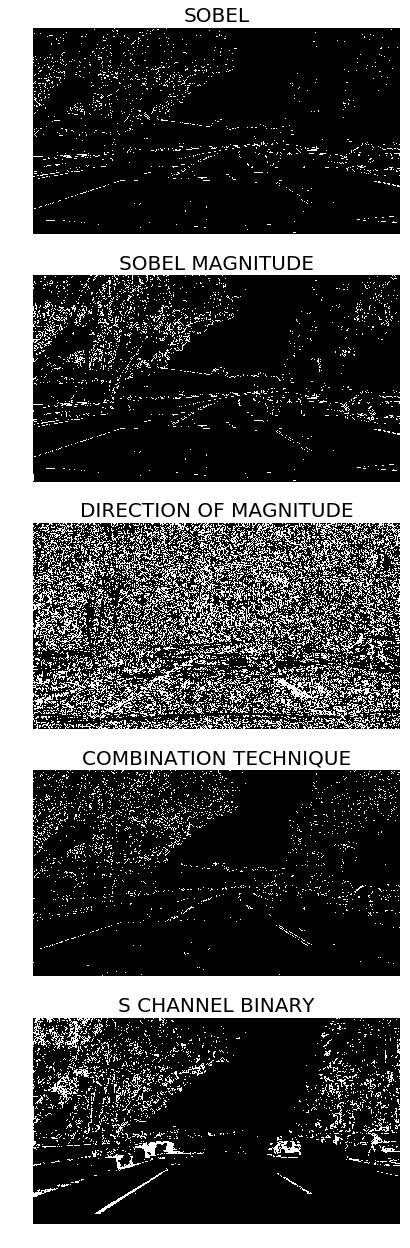

In [106]:
#
#  idx == 1 : test5.jpg -- has a shadow over the road so that there are much contrast on the road and the lane lines.
#

for idx,(sobel,mag,direct,combi,hls) in enumerate(zip(sobel_images,mag_images,dir_images,combination_binary_images,hls_images)):
    if idx == 1:
        plt.figure(figsize=(26,22))
        #plt.suptitle("Compare.", fontsize=24)
        plt.subplot(5,1,1)
        plt.imshow(sobel, cmap = "gray")
        plt.title("SOBEL",fontsize=20)
        plt.axis('off')

        plt.subplot(5,1,2)
        plt.imshow(mag, cmap = "gray")
        plt.title("SOBEL MAGNITUDE",fontsize=20)
        plt.axis('off')

        plt.subplot(5,1,3)
        plt.imshow(direct, cmap = "gray")
        plt.title("DIRECTION OF MAGNITUDE",fontsize=20)
        plt.axis('off')

        plt.subplot(5,1,4)
        plt.imshow(combi, cmap = "gray")
        plt.title("COMBINATION TECHNIQUE",fontsize=20)
        plt.axis('off')

        plt.subplot(5,1,5)
        plt.imshow(hls, cmap = "gray")
        plt.title("S CHANNEL BINARY",fontsize=20)
        plt.axis('off')
        
        
        


(-0.5, 1279.5, 719.5, -0.5)

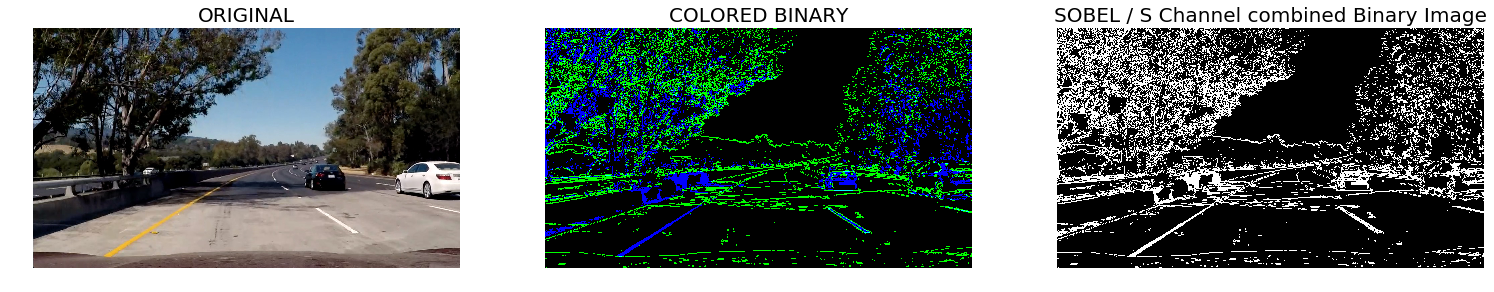

In [86]:
#
# colored binary is 3 channel to integrate binary images (eg. sobel / S_channel etc.)
#

color_binary = np.zeros_like(sobel_images[1])
color_binary = np.dstack(( np.zeros_like(sobel_images[1]), sobel_images[1], hls_images[1])) * 255

combined_binary = np.zeros_like(hls_images[1])
combined_binary[ (sobel_images[1] == 1)  | ( hls_images[1] == 1) ] = 1


plt.figure(figsize=(26,22))
#plt.suptitle("Compare.", fontsize=24)
plt.subplot(1,3,1)
plt.imshow(images[1] )
plt.title("ORIGINAL COLORED IMAGE",fontsize=20)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(color_binary)
plt.title("COLORED BINARY",fontsize=20)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(combined_binary, cmap = "gray")
plt.title("SOBEL / S Channel combined Binary Image",fontsize=20)
plt.axis('off')



## Histogram Equalizer - Open CV Python (package book)
* The human eye likes contrast, and so we need to adjust the contrast to make the image look nice and pleasant. A lot of cameras and photo applications implicitly do this already. We use a process called Histogram Equalization to achieve this.